<a href="https://colab.research.google.com/github/VJared/ECE-4554-5554-group12/blob/master/visual_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prep Work**

In [ ]:
!pip install fastai
!pip install annoy
!pip install gdown
!pip install plotly_express

In [173]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile 
from google.colab import drive
from sklearn.manifold import TSNE
import plotly_express as px
from PIL import Image, ImageDraw
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get DeepFashion (2.6 GB)
root_path = './'
gdown.download('https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb', 'img.zip', quiet=False)
with zipfile.ZipFile("img.zip","r") as unzip:
    unzip.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [00:36, 72.8MB/s]


In [ ]:
# create a list of all category names, need to download the files listed from DeepFashion
categories = []
with open('drive/MyDrive/list_category_cloth.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      categories.append(line.split(' ')[0]) # append category name
# create a list of paths to images in dataset
imgpaths = []
with open('drive/MyDrive/list_category_img.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      imgpaths.append([data.strip() for data in line.split(' ') if len(data) > 0]) # append <img path>, <category type>

# training/validation/test images
img_data_type = []
with open('drive/MyDrive/list_eval_partition.txt', 'r') as f:
  for i, line in enumerate(f.readlines()):
    if i > 1:
      img_data_type.append([data.strip() for data in line.split(' ') if len(data) > 0]) # append <img path>, <data type>

In [ ]:
# create a single data frame for image data
# we want to store image path, data type, category number

df = pd.DataFrame(imgpaths, columns=['image_path', 'category'])
df['category'] = pd.to_numeric(df['category'])
df = df.merge(pd.DataFrame(img_data_type, columns=['image_path', 'data_type']), on='image_path')
df['category'] = df['category'].apply(lambda x: categories[x - 1]) # replace category numbers with category names
print(df.head())

# data summary
print(len(df))

                                        image_path category data_type
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   Blouse     train
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   Blouse     train
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   Blouse       val
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   Blouse     train
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   Blouse      test
289222


In [ ]:
# Use Fast AI to generate embeddings
train_data = ImageList.from_df(df=df, 
                               path='./', 
                               cols='image_path',
).split_by_idxs(
                (df[df['data_type'] == 'train'].index),
                (df[df['data_type'] == 'val'].index),
).label_from_df(cols='category')

data = train_data.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
test_data = ImageList.from_df(df=df[df['data_type'] == 'test'], path='./', cols='image_path')
data.add_test(test_data)

In [ ]:
# load model after transfer learning
model_dir = '/content/drive/MyDrive/resnet18-DeepFashion'
pretrained_model = models.resnet18
metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = cnn_learner(data, pretrained_model, metrics=metrics) #create model instance
learner.model = torch.nn.DataParallel(learner.model) # utilize gpu
#learner = learner.load(model_dir) # load model


In [ ]:
# load saved features as numpy array
features = np.load('/content/drive/MyDrive/saved_features.npy')

In [ ]:
# prepare data for generating recommendations
reclib_paths = list(data.train_ds.items) + list(data.valid_ds.items)
reclib_ids = list(data.train_ds.y.items) + list(data.valid_ds.y.items)
img_paths = [str(path) for path in reclib_paths]
label_ids = [id for id in reclib_ids]
labels = [data.classes[id] for id in reclib_ids]
rec_df = pd.DataFrame({'img_path': img_paths, 'label': labels, 'label_id': label_ids})
rec_df['embeddings'] = features.tolist()

In [ ]:
# creates a hook to save features from resnet model
class SaveFeatures():
  features = None
  def __init__(self, model_layer):
    self.hook = model_layer.register_forward_hook(self.hook_fn)
    self.features = None
  def hook_fn(self, module, input, output):
    out = output.detach().cpu().numpy()
    if isinstance(self.features, type(None)):
      self.features = out
    else:
      self.features = np.row_stack((self.features, out))
  def remove(self):
    self.hook.remove()

In [ ]:
# build annoy tree
n_subtrees = 100
f = len(rec_df['embeddings'][0])
query_metric = 'angular'
query_tree = AnnoyIndex(f, metric=query_metric)

# populate with feature vectors
for i, vec in enumerate(rec_df['embeddings']):
  query_tree.add_item(i, vec)

# build with subtrees
_ = query_tree.build(n_subtrees)

#**User Execution**

In [291]:
# open user images
src_path = 'input2.jpg'
user_img = open_image(src_path)
user_features = SaveFeatures(learner.model.module[1][4])
_= learner.predict(user_img)

In [292]:
def get_similar_images_annoy(vec):
  similar_img_ids = query_tree.get_nns_by_vector(vec, 9)
  return rec_df.iloc[similar_img_ids]

def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    for i, img in enumerate(images):
      img.show(title=str(i+1) + " - " + similar_images_df.iat[i, 1])

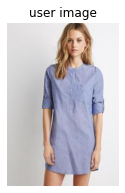

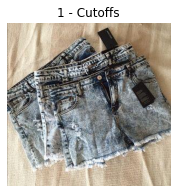

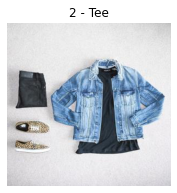

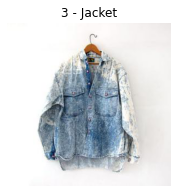

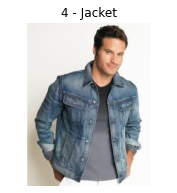

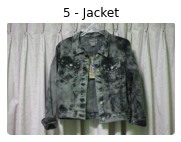

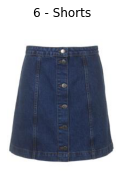

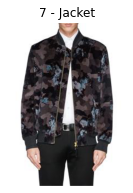

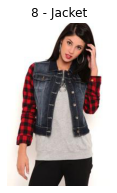

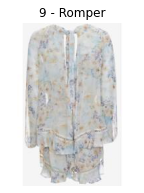

In [293]:
user_img.show(title='user image')
similar_images_df = get_similar_images_annoy(user_features.features[0])
show_similar_images(similar_images_df)

#**TSNE**

In [294]:
# generate tsne plot
similar_images_df = similar_images_df.append({'img_path': src_path, 'label': 'user_img', 'label_id': -1, 'embeddings': user_features.features[0]}, ignore_index=True)
index = list(range(1,len(similar_images_df),1))
index = [str(a) for a in index]
index.append("user image")
similar_images_df['index'] = index
print(similar_images_df)
embeddings = [list(x) for x in similar_images_df['embeddings']]
tsne = TSNE(n_components=3, n_iter=500, verbose=1)
results = tsne.fit_transform(embeddings)
similar_images_df['dim1'] = results[:,0]
similar_images_df['dim2'] = results[:,1]
similar_images_df['dim3'] = results[:,2]
similar_images_df.to_parquet('deepFashion_similar_images')
fig = px.scatter_3d(similar_images_df, x='dim1', y='dim2', z='dim3', symbol='label', color='index',
                    labels={"label": "Label", "index": "Image Number"})
fig.show()

                                            img_path  ...       index
0  ./img/Distressed_Low-Rise_Cutoffs/img_00000010...  ...           1
1       ./img/Distressed_Pocket_Tee/img_00000037.jpg  ...           2
2  ./img/Destroyed_Acid_Wash_Denim_Jacket/img_000...  ...           3
3          ./img/Faded_Denim_Jacket/img_00000006.jpg  ...           4
4       ./img/Bleached_Denim_Jacket/img_00000051.jpg  ...           5
5  ./img/Buttoned-Front_Denim_Shorts/img_00000014...  ...           6
6  ./img/Floral_Print_Bomber_Jacket/img_00000072.jpg  ...           7
7   ./img/Mineral_Wash_Denim_Jacket/img_00000029.jpg  ...           8
8  ./img/Layered_Floral_Print_Romper/img_00000028...  ...           9
9                                         input2.jpg  ...  user image

[10 rows x 5 columns]
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] M